In [1]:
import os
import math
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from hydroeval import nse, kge, pbias

from fancyimpute import IterativeImputer as MICE
from fancyimpute import NuclearNormMinimization, SoftImpute

import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, Dense, Dropout, BatchNormalization, ConvLSTM2D, Bidirectional, Flatten
from keras.callbacks import ReduceLROnPlateau
from keras import backend

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# from sklearn.impute import SimpleImputer

In [2]:
def get_grdc(grdc_no):
    data_date_month = []
    data_date_common = []
    data_value = []
    f = open("aus_data2/" + grdc_no + "_Q_Day.Cmd.txt", "rb")
    for i in f:
        i = str(i)[2:-5]
        if "#" in i:
            continue
        if "YYYY" in i:
            continue
        temp = [i.strip() for i in i.split(";")]
        date_temp = temp[0].split("-")
        date_temp = [i.strip() for i in temp[0].split("-")]
        data_date_month.append(int(date_temp[1]))
        data_date_common.append(date_temp[0] + "-" + date_temp[1] + "-" + date_temp[2])
        data_value.append(round(float(temp[2]), 3))
    df_temp = pd.DataFrame(list(zip(data_date_month, data_value, data_date_common)),
                               columns =["Month", "Value", "Date"])
    df_temp = df_temp.set_index('Date')
    df_temp = df_temp[df_temp["Month"] != 0]
    df_temp.sort_index()
    df_index = df_temp.index
    df_temp.replace(-999.0, np.nan, inplace=True)
    
    return df_temp

In [3]:
def get_data(f):
    
    value = []
    common = []
    
    grdc_no = ""
    latitude = ""
    longitude = ""
    
    for i in f:
        
        i = str(i)[2:-5]
        
        if "GRDC-No" in i:
            grdc_no = i.split(":")[1].strip()
            continue
        elif "Latitude" in i:
            latitude = i.split(":")[1].strip()
            continue
        elif "Longitude" in i:
            longitude = i.split(":")[1].strip()
            continue
        elif "YYYY" in i:
            continue
        elif "#" in i:
            continue

        temp = [i.strip() for i in i.split(";")]
        date_temp = temp[0].split("-")
        date_temp = [i.strip() for i in temp[0].split("-")]
        common.append(date_temp[0] + "-" + date_temp[1] + "-" + date_temp[2])
        value.append(round(float(temp[2]), 3))
        
    return value, common, grdc_no, latitude, longitude

In [4]:
def merged(x, x_ncdc):
    
    x = x.set_index('Date')
    x.sort_index()
    x_ncdc = x_ncdc.set_index('DATE')
    x_ncdc.sort_index()
    
    x_first = x.index[0] if x.index[0] > x_ncdc.index[0] else x_ncdc.index[0]
    x_last = x.index[-1] if x.index[-1] < x_ncdc.index[-1] else x_ncdc.index[-1]
    merged = pd.concat([x, x_ncdc], axis=1, sort=True)
    to_delete = []
    for i, r in merged.iterrows():
        if i < x_first or i > x_last:
            to_delete.append(i)
            
    merged = merged.drop(to_delete)
    
    return merged

In [5]:
#Combines climate and rainfall data


all_data = {}

for filename in os.listdir("aus_data2/"):

    f = open("aus_data2/" + filename, "rb")
    f2 = pd.read_csv("NCDC_4/" + filename[:7] + ".csv")

    value, common, grdc_no, latitude, longitude = get_data(f)
    f.close()

    df_temp = pd.DataFrame(list(zip(value, common)), columns =["Value", "Date"])
    df_temp = merged(df_temp, f2)
    df2 = df_temp["Value"]
    df2 = df2.replace(-999.0, np.nan)
    df2 = df2.fillna(df2.mean())
    first_index = df_temp["LONGITUDE"].first_valid_index()
    temp_dict = {
        "GRDC_latitude": latitude,
        "GRDC_longitude": longitude,
        "NCDC_latitude": df_temp["LATITUDE"][first_index],
        "NCDC_longitude": df_temp["LONGITUDE"][first_index],
        "Elevation": df_temp["ELEVATION"][first_index]
    }
    cols = list(df_temp.columns)
    cols_to_keep = []
    for i in cols:
        if len(i) == 4 and i != "NAME":
            cols_to_keep.append(i)
            cols.remove(i)
    df_temp.drop(columns=cols, inplace=True)
    df_temp.sort_index()
    df_index = df_temp.index
    soft_impute = SoftImpute(max_iters=300, verbose=False)
    df_temp = soft_impute.fit_transform(df_temp)
#     df_temp = SimpleImputer(strategy='mean').fit_transform(df_temp)

    df_temp = pd.DataFrame(data=df_temp, columns=cols_to_keep)
    if "PRCP" in cols_to_keep:
        df_temp[df_temp["PRCP"] < 0] = 0
    if "SNWD" in cols_to_keep:
        df_temp[df_temp["SNWD"] < 0] = 0
    df_temp["Date"] = df_index
    df_temp = df_temp.set_index(["Date"])
    df_temp["t-1"] = df2.shift(1)
    df_temp = df_temp.replace(np.nan, 0)
    temp_dict["data_x"] = df_temp
    temp_dict["data_y"] = df2
    all_data[grdc_no] = temp_dict

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (9,11,17,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/pbidada/.local/lib/python3.8/site-packages/fancyimpute/solver.py:55: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")


In [6]:
all_data

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'5101250': {'GRDC_latitude': '-21.1425',
  'GRDC_longitude': '149.051667',
  'NCDC_latitude': -21.1422,
  'NCDC_longitude': 149.0381,
  'Elevation': 26.0,
  'data_x':                     DAPR          DWPR          MDPR  PRCP  t-1
  Date                                                           
  1916-10-01  4.364930e-17  2.929926e-18 -1.152986e-16  0.00  0.0
  1916-10-02  3.817718e-17  2.034584e-17  5.857055e-17  0.00  2.0
  1916-10-03  0.000000e+00  0.000000e+00  0.000000e+00  0.00  2.0
  1916-10-04  0.000000e+00  0.000000e+00  0.000000e+00  0.00  2.0
  1916-10-05  0.000000e+00  0.000000e+00  0.000000e+00  0.15  2.0
  ...                  ...           ...           ...   ...  ...
  1982-12-10  0.000000e+00  0.000000e+00  0.000000e+00  0.00  0.0
  1982-12-11  0.000000e+00  0.000000e+00  0.000000e+00  0.00  0.0
  1982-12-12  0.000000e+00  0.000000e+00  0.000000e+00  0.00  0.0
  1982-12-13  0.000000e+00  0.000000e+00  0.000000e+00  0.00  0.0
  1982-12-14  0.000000e+00  0.000000e+00  

In [7]:
pickle.dump(all_data, open("save_soft_impute.p", "wb"))

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-7-c49f75f7565d>:1: ResourceWarning: unclosed file <_io.BufferedWriter name='save_soft_impute.p'>
  pickle.dump(all_data, open("save_soft_impute.p", "wb"))


In [8]:
all_data = pickle.load(open( "save_soft_impute.p", "rb" ))

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-8-04618af837ac>:1: ResourceWarning: unclosed file <_io.BufferedReader name='save_soft_impute.p'>
  all_data = pickle.load(open( "save_soft_impute.p", "rb" ))


In [9]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
new_data_x = all_data["5204102"]["data_x"]
new_data_y = all_data["5204102"]["data_y"]

new_data_y2 = np.asarray(new_data_y).reshape((-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
new_data_x2 = scaler.fit_transform(new_data_x)
new_data_y2 = scaler.fit_transform(new_data_y2)
dataset = np.hstack((new_data_x2, new_data_y2))
X, y = split_sequences(dataset, 3)

train_size = round(0.8*new_data_x2.shape[0])
X_train = new_data_x2[:train_size]
y_train = new_data_y2[:train_size]
X_test = new_data_x2[train_size:]
y_test = new_data_y2[train_size:]
X_train2 = np.asarray(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
y_train2 = np.asarray(y_train)
X_test2 = np.asarray(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)
y_test2 = np.asarray(y_test)


model = Sequential()
model.add(LSTM(30, activation = 'relu' ,input_shape=[X_train2.shape[1], X_train2.shape[2]]))

model.add(Dense(1))
model.summary()
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 8)                 80        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
new_data_x.shape

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(39839, 5)

In [58]:
history = model.fit(X_train2, y_train2 ,epochs = 50)

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Epoch 1/50
996/996 [==============================] - 5s 5ms/step - loss: 0.0063 - root_mean_squared_error: 0.0204
Epoch 2/50
996/996 [==============================] - 5s 5ms/step - loss: 0.0033 - root_mean_squared_error: 0.0113
Epoch 3/50
996/996 [==============================] - 5s 5ms/step - loss: 0.0033 - root_mean_squared_error: 0.0113
Epoch 4/50
996/996 [==============================] - 5s 5ms/step - loss: 0.0032 - root_mean_squared_error: 0.0113
Epoch 5/50
996/996 [==============================] - 5s 5ms/step - loss: 0.0032 - root_mean_squared_error: 0.0113
Epoch 6/50
996/996 [==============================] - 5s 5ms/step - loss: 0.0032 - root_mean_squared_error: 0.0112
Epoch 7/50
996/996 [==============================] - 5s 5ms/step - loss: 0.0032 - root_mean_squared_error: 0.0112
Epoch 8/50
996/996 [==============================] - 5s 5ms/step - loss: 0.0032 - root_mean_squared_error: 0.0113
Epoch 9/50
996/996 [==============================] - 5s 5ms/step - loss: 0.0032

In [59]:
temp = model.evaluate(X_test2,y_test2)
print("Mean Absolute Error - " , temp[0])
print("Root Mean Squared Error - " , temp[1]*100)

  1/249 [..............................] - ETA: 0s - loss: 0.0119 - root_mean_squared_error: 0.0176

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


249/249 [==============================] - 0s 2ms/step - loss: 0.0037 - root_mean_squared_error: 0.0088
Mean Absolute Error -  0.003710157936438918
Root Mean Squared Error -  0.8785160258412361


In [60]:
results_train = model.predict(X_train2)
results_test = model.predict(X_test2)

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [61]:
# 2969101
# 2969100
station = "5204102"
test_new_x = np.asarray(all_data[station]["data_x"])
test_new_y = np.asarray(all_data[station]["data_y"])

test_new_y = np.asarray(test_new_y).reshape((-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
test_new_x = scaler.fit_transform(test_new_x)
test_new_y = scaler.fit_transform(test_new_y)
test_new_x = test_new_x.reshape((test_new_x.shape[0], test_new_x.shape[1], 1))

results = model.predict(test_new_x)

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
results

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0.00022073],
       [0.01519892],
       [0.01567368],
       ...,
       [0.01010543],
       [0.00984557],
       [0.01096181]], dtype=float32)

In [ ]:
plt.figure(figsize=(20,5))
plt.plot([i for i in range(len(y_test))], y_test)
# plt.plot([i for i in range(len(test_new_y))], test_new_y)
plt.plot([i for i in range(len(results_test))], results_test)
plt.show()

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


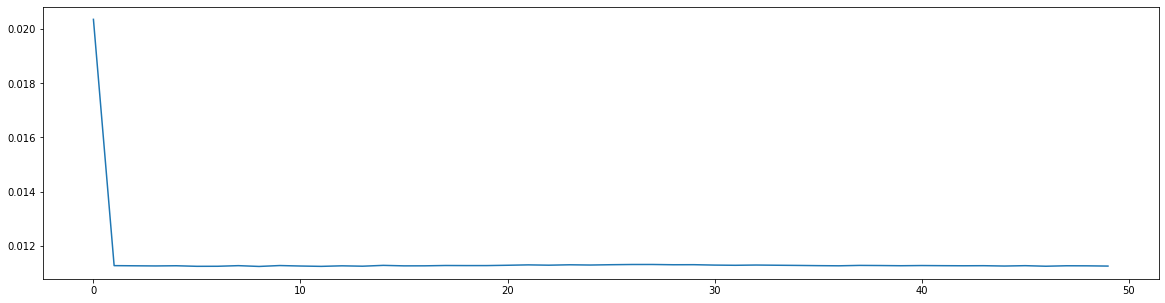

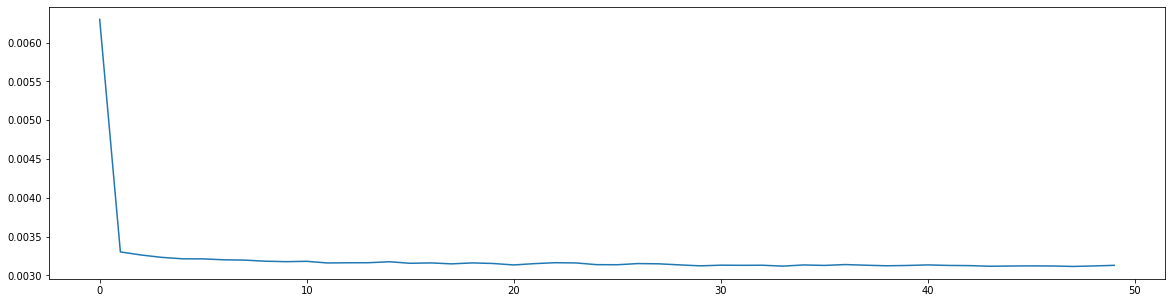

In [64]:
plt.figure(figsize=(20,5))
plt.plot(history.history["root_mean_squared_error"])
plt.figure(figsize=(20,5))
plt.plot(history.history["loss"])
plt.show()

In [65]:
x_labels = []
for i in range(0,len(new_data_y[train_size:]), 200):
#     print(i)
    x_labels.append(new_data_y.index[i])
    
print(len(x_labels))

40


/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
trainPredict = scaler.inverse_transform(results_train)
trainY = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(results_test)
testY = scaler.inverse_transform(y_test)

plt.figure(figsize=(20,5))

plt.plot(testY, label="Actual")
plt.plot(testPredict, label="Predicted")
plt.xticks(range(0,len(new_data_y[train_size:]), 200), x_labels)
plt.legend(['Actual','Predicted'])
plt.xlabel("Date")
plt.ylabel("Water Runoff")
plt.show()

In [67]:
testY = testY.reshape(-1)
testPredict = testPredict.reshape(-1)

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [68]:
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import r2_score

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [69]:
nmi_score = normalized_mutual_info_score(testY, testPredict)

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
nmi_score

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.9682755381942647

In [71]:
r_score = r2_score(testY, testPredict)

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:
r_score

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.9431857469779874

In [74]:
from sklearn.ensemble import RandomForestRegressor

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
regr = RandomForestRegressor(criterion="mae")

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [76]:
y_train_random_forest = y_train.reshape(-1)
y_test_random_forest = y_test.reshape(-1)

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
regr.fit(X_train, y_train_random_forest)

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RandomForestRegressor(criterion='mae')

In [78]:
random_f = regr.predict(X_test)

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [79]:
random_f = random_f.reshape(-1,1)

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [80]:
testPredict_random = scaler.inverse_transform(random_f)

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


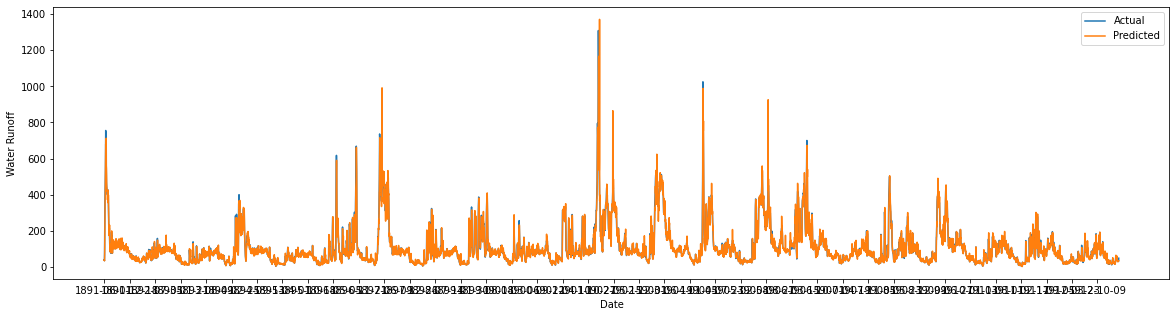

In [81]:
plt.figure(figsize=(20,5))
plt.plot(testY, label="Actual")
plt.plot(testPredict_random, label="Predicted")
plt.xticks(range(0,len(new_data_y[train_size:]), 200), x_labels)
plt.legend(['Actual','Predicted'])
plt.xlabel("Date")
plt.ylabel("Water Runoff")
plt.show()

In [82]:
testPredict_random = testPredict_random.reshape(-1)

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [83]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [84]:
mae_random_forest = mean_absolute_error(testY, testPredict_random)
rmse_random_forest = mean_squared_error(testY, testPredict_random, squared=False)
nmi_random_forest = normalized_mutual_info_score(testY, testPredict_random)
r_random_forest = r2_score(testY, testPredict_random)

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [85]:
r_random_forest

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.9316135933050498

In [86]:
from sklearn.base import clone
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import SGDRegressor

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [87]:
clf = Ridge(alpha=1.0)
clf.fit(X_train, y_train_random_forest)

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Ridge()

In [88]:
random_f = clf.predict(X_test)

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [89]:
random_f = random_f.reshape(-1,1)
testPredict_random = scaler.inverse_transform(random_f)

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


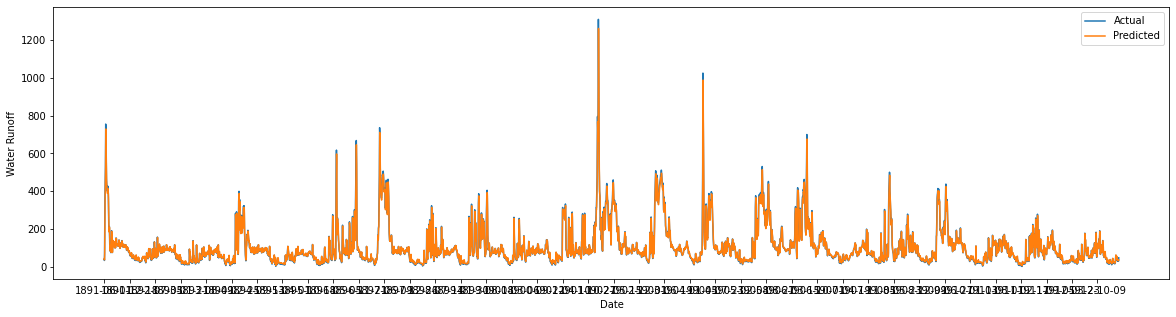

In [90]:
plt.figure(figsize=(20,5))
plt.plot(testY, label="Actual")
plt.plot(testPredict_random, label="Predicted")
plt.xticks(range(0,len(new_data_y[train_size:]), 200), x_labels)
plt.legend(['Actual','Predicted'])
plt.xlabel("Date")
plt.ylabel("Water Runoff")
plt.show()

In [91]:
from sklearn.svm import SVR

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
f = open("metrics1.csv", "w")
f.write("Station_id,Latitude,Longitude,NMI,R_Squared,MAE,RMSE,NSE,pBias")
f.write("\n")
for i in all_data:
    test_new_x = np.asarray(all_data[i]["data_x"])
    test_new_y = np.asarray(all_data[i]["data_y"])

    test_new_y = np.asarray(test_new_y).reshape((-1, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    test_new_x = scaler.fit_transform(test_new_x)
    test_new_y = scaler.fit_transform(test_new_y)
    test_new_x = test_new_x.reshape((test_new_x.shape[0], test_new_x.shape[1], 1))
    
    results = model.predict(test_new_x)
    
    testY = test_new_y.reshape(-1)
    testPredict = results.reshape(-1)
    
    nmi_score = normalized_mutual_info_score(testY, testPredict)
    r_score = r2_score(testY, testPredict)
    mae = mean_absolute_error(testY, testPredict)
    rmse = mean_squared_error(testY, testPredict, squared=False)
    nse_ = nse(testPredict, testY)
#     kge_ = kge(testPredict, testY)
    pbias_ = pbias(testPredict, testY)
    
    f.write(str(i)+","+str(all_data[i]["GRDC_latitude"])+","+str(all_data[i]["GRDC_longitude"])+","+str(nmi_score)+","+str(r_score)+","+str(mae)+","+str(rmse)+","+str(nse_)+","+str(pbias_))
    f.write("\n")
    

    
f.close()

/home/pbidada/.conda/envs/tf_gpu_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
